In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/home/yuncong/project/cython-munkres-wrapper/build/lib.linux-x86_64-2.7')
from munkres import munkres

import os
import time

from utilities2015 import *

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, single, complete

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.measure import find_contours
from skimage.util import img_as_float

import matplotlib.pyplot as plt
%matplotlib inline

from networkx import from_dict_of_lists, Graph, adjacency_matrix, dfs_postorder_nodes
from networkx.algorithms import node_connected_component

from shape_matching import *

In [2]:
stack_name = 'MD593'

dms = dict([(sec_ind, DataManager(stack=stack_name, section=sec_ind, segm_params_id='tSLIC200')) 
       for sec_ind in [139, 140]])

In [3]:
def boundary_distance(b1, b2, loc_thresh=1500, verbose=False):
    
    _, interior_texture1, exterior_textures1, points1, center1, \
                        majorv1, minorv1, majorlen1, minorlen1, ell_center1 = b1
        
    _, interior_texture2, exterior_textures2, points2, center2, \
                        majorv2, minorv2, majorlen2, minorlen2, ell_center2 = b2
    
    # compute location difference
    d_loc = np.linalg.norm(center1 - center2)
    D_loc = np.maximum(0, d_loc - 500)
    
    if d_loc > loc_thresh:
        return np.inf
    
    n1 = len(points1)
    n2 = len(points2)
    
    if max(n1,n2) > min(n1,n2) * 3:
        return np.inf
    
    # compute interior texture difference
    D_int = chi2(interior_texture1, interior_texture2)

#     D_area = len(multidim_intersect(coords1, coords2))/1e5
    
    d = D_int + D_loc
    return d

In [4]:
from skimage.util import pad

def generate_matching_visualizations(sec1, sec2, matchings=None):
    '''
    Generate visualization for matching between sec1 and sec2
    '''
    
    dm1 = dms[sec1]
    dm2 = dms[sec2]
    
    boundaries1 = dm1.load_pipeline_result('boundaryModels')
    boundaries2 = dm2.load_pipeline_result('boundaryModels')
    
    if matchings is None:
        matchings = dm1.load_pipeline_result('matchings%dWith%d'%(sec1, sec2))

    matched_boundaries1 = [boundaries1[i][0] for ind, (d,i,j) in enumerate(matchings)]
    vis_matched_boundaries_next = dm1.visualize_edge_sets(matched_boundaries1, show_set_index=True)

    matched_boundaries2 = [boundaries2[j][0] for ind, (d,i,j) in enumerate(matchings)]
    vis_matched_boundaries_prev = dm2.visualize_edge_sets(matched_boundaries2, show_set_index=True)

    # Place two images vertically 
    h1, w1 = vis_matched_boundaries_next.shape[:2]
    h2, w2 = vis_matched_boundaries_prev.shape[:2]
    
    if w1 < w2:
        left_margin = int((w2 - w1)/2)
        right_margin = w2 - w1 - left_margin
        vis_matched_boundaries_next = pad(vis_matched_boundaries_next, 
                                          ((0,0),(left_margin,right_margin),(0,0)), 
                                          'constant', constant_values=255)
    else:
        left_margin = int((w1 - w2)/2)
        right_margin = w1 - w2 - left_margin
        vis_matched_boundaries_prev = pad(vis_matched_boundaries_prev, 
                                          ((0,0),(left_margin,right_margin),(0,0)), 
                                          'constant', constant_values=255)
        
    vis = np.r_[vis_matched_boundaries_next, vis_matched_boundaries_prev]
    
    return vis

In [5]:
def multidim_intersect(arr1, arr2):
    arr1_view = arr1.view([('',arr1.dtype)]*arr1.shape[1])
    arr2_view = arr2.view([('',arr2.dtype)]*arr2.shape[1])
    intersected = numpy.intersect1d(arr1_view, arr2_view)
    return intersected.view(arr1.dtype).reshape(-1, arr1.shape[1])

In [6]:
dm1 = dms[139]
dm2 = dms[140]
    
boundaries1 = dm1.load_pipeline_result('boundaryModels')
boundaries2 = dm2.load_pipeline_result('boundaryModels')

In [14]:
res = boundary_distance(boundaries1[1], boundaries2[23], verbose=True)

In [7]:
def compute_boundary_distances(sec1, sec2, verbose=False):
    
    dm1 = dms[sec1]
    dm2 = dms[sec2]
    
    boundaries1 = dm1.load_pipeline_result('boundaryModels')
    boundaries2 = dm2.load_pipeline_result('boundaryModels')
    
#     sc1 = dm1.load_pipeline_result('shapeContext')
#     sc2 = dm2.load_pipeline_result('shapeContext')

    n_boundaries1 = len(boundaries1)
    n_boundaries2 = len(boundaries2)
    
    center_dist_thresh = 1500
    
    centers1 = [b[4] for b in boundaries1]
    centers2 = [b[4] for b in boundaries2]
    center_distances = cdist(centers1, centers2, metric='euclidean')
    b1s, b2s = np.where(center_distances < center_dist_thresh)
    
    b = time.time()
    
    Ds = []
    for i, j in zip(b1s, b2s):
#         sys.stderr.write('%d,%d\n'%(i,j))
        d = boundary_distance(boundaries1[i], boundaries2[j], verbose=verbose)
        Ds.append(d)
        
#     Ds = Parallel(n_jobs=2)(delayed(boundary_distance)(boundaries1[i], boundaries2[j], verbose=verbose) 
#                              for i, j in zip(b1s, b2s))
    print  'boundary_distance', time.time() - b

    Ds_mat = np.inf * np.ones((n_boundaries1, n_boundaries2))
    Ds_mat[b1s, b2s] = Ds
    
    return Ds_mat
    
#     D_boundaries = np.inf * np.ones((n_boundaries1, n_boundaries2))
#     D_int = np.inf * np.ones((n_boundaries1, n_boundaries2))
#     D_ext = np.inf * np.ones((n_boundaries1, n_boundaries2))
#     D_shape = np.inf * np.ones((n_boundaries1, n_boundaries2))
    
#     D_boundaries[b1s, b2s] = [d for d, d_int, d_ext, d_shape, d_loc in Ds]
#     D_int[b1s, b2s] = [d_int for d, d_int, d_ext, d_shape, d_loc in Ds]
#     D_ext[b1s, b2s] = [d_ext for d, d_int, d_ext, d_shape, d_loc in Ds]
#     D_shape[b1s, b2s] = [d_shape for d, d_int, d_ext, d_shape, d_loc in Ds]
    
#     return D_boundaries, D_int, D_ext, D_shape

In [9]:
Ds = compute_boundary_distances(139, 140, verbose=True)

boundary_distance 0.0636401176453


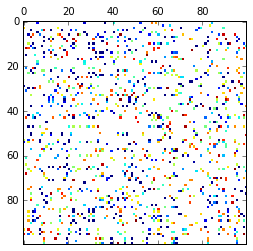

In [10]:
plt.matshow(Ds);

In [11]:
from bipartite_matching import *

In [12]:
def match_landmarks(sec1, sec2, D=None, must_match=[], cannot_match=[]):
    
    dm1 = dms[sec1]
    dm2 = dms[sec2]
    boundaries1 = dm1.load_pipeline_result('boundaryModels')
    boundaries2 = dm2.load_pipeline_result('boundaryModels')
    
    if D is None:
        D = dm1.load_pipeline_result('DBoundaries%dWith%d'%(sec1, sec2))
        
    matchings = knn_matching(D, boundaries1, boundaries2)
    matchings = sorted(matchings)
    
    return matchings

In [13]:
match = match_landmarks(139, 140, D=Ds)

In [14]:
match

[(0.010513782200418636, 99, 48),
 (0.012938520394720886, 9, 9),
 (0.015839721147262724, 65, 96),
 (0.016131350370247485, 92, 98),
 (0.017340750047535318, 86, 70),
 (0.020273979011567321, 53, 20),
 (0.023193798332892663, 81, 86),
 (0.024561232736321149, 80, 82),
 (0.02922180682965789, 10, 61),
 (0.033884336420681331, 79, 63),
 (0.034584032242010725, 88, 52),
 (0.038041765263642349, 37, 79),
 (0.039312765844794803, 87, 58),
 (0.040640292591774388, 4, 17),
 (0.042826098936763687, 15, 14),
 (0.043471924654963218, 13, 18),
 (0.044438187779305291, 45, 85),
 (0.046774337815874395, 78, 38),
 (0.048370751608931978, 39, 83),
 (0.048529856887527659, 74, 99),
 (0.048987250691722196, 84, 22),
 (0.053628604623709504, 90, 23),
 (0.054836916188266978, 46, 62),
 (0.056136895337317555, 72, 27),
 (0.058801320425694588, 20, 65),
 (0.061442433961574235, 89, 31),
 (0.064920288245699273, 93, 7),
 (0.065423937126351236, 47, 87),
 (0.069475659028880976, 21, 5),
 (0.078499143516324477, 61, 19),
 (0.085892800584

In [15]:
viz = generate_matching_visualizations(139, 140, matchings=match[:10])
display(viz)

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2261: DecompressionBombWarning: Image size (203470848 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [28]:
match2 =[(s, i,j) for s,i,j in  match if s < 1]

In [29]:
match2

[(0.010485786513321346, 68, 71),
 (0.023723150392245453, 55, 50),
 (0.024516289979832163, 65, 37),
 (0.024917937259280244, 12, 25),
 (0.028757157119708728, 16, 6),
 (0.031018372851846866, 25, 49),
 (0.033471923439044572, 40, 44),
 (0.033596003857835108, 39, 56),
 (0.035026106964857098, 69, 51),
 (0.035942888528010829, 66, 59),
 (0.039928982148556426, 52, 53),
 (0.043178876165048015, 53, 60),
 (0.048579837281596136, 32, 20),
 (0.053276520959028073, 10, 2),
 (0.053810765115342087, 22, 62),
 (0.058218225513241906, 58, 66),
 (0.072222508194473636, 63, 34),
 (0.077418343778801496, 8, 32),
 (0.080747539154569559, 33, 11),
 (0.088007318611514784, 26, 24),
 (0.098695895072666101, 71, 41),
 (0.10501160025851936, 28, 15),
 (0.11081925474898384, 3, 12),
 (0.11340180998015041, 21, 10),
 (0.11597363803652097, 62, 61),
 (0.11702413194431464, 19, 16),
 (0.13870728890346368, 0, 18),
 (0.17161087355325394, 24, 28),
 (0.24121309313168879, 6, 7),
 (0.24218215667983575, 4, 1),
 (0.24823433501092845, 9, 43

In [33]:
viz = generate_matching_visualizations(138, 139, matchings=match2[5:10])

In [34]:
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg